---


STOCHASTIC FORCING of (balanced) TURBULENCE
===

In French: Forçage Stochastique de la Turbulence (FSTURB)

This configuration aims at generating slow/balanced turbulence with a stochatic forcing generated in horizontal wavenumber space.
Three dimension forcing fields are generated every $\Delta t$ (*fst_dt* in code) seconds and then linearly interpolated at every time step:

$$
\begin{align}
F(i,j,k,t) &= \frac{(n+1)\Delta t-t}{\Delta t} F_{n\Delta t}(i,j,k) 
+ \frac{t-n\Delta t}{\Delta t} F_{(n+1)\Delta t}(i,j,k) 
\\
\mathrm{for}\;\; n\Delta t&<t<(n+1)\Delta t
\end{align}
$$


The spatial structure of forcing fields are given by:

$$
\begin{align}
F_{n\Delta t}(i,j,k) = 
F_{T} \; 
W(i,j) \;
\times
iFFT
\Big \{
\sum_{m} N_{n\Delta t}(kx,ky,m) \psi(kx,ky,m) \phi_{m}(k)
\Big \}
\end{align}
$$

$ F_{T} $ is a constant corresponding to density forcing (will be declined into $ F_{u}, F_{v} $ later on ).

$ W(i,j) $ is a window that may tapper the forcing in physical space. 
Current implementation tappers in the y direction:

$$ W(i,j) = [1.+\tanh{((y-y_{F}+\Delta y_{F})/\delta_{y_F}}] 
\times [1.-\tanh{((y-y_{F}-\Delta y_{F})/\delta_{y_F}}]
/4$$
or (older version)
$$ W(i,j) = e^{-((y-y_{F})/(\Delta y_{F}))^{2}} $$

$N_{n\Delta t}(kx,ky,m)$ is a normal white noise.

$ \psi(kx,ky,m) $ is constant through the course of thenumerical simulation and modulates the forcing amplitude spectrally (horizontal, vertical modes).

$$ 
\psi (kx,ky,m)= \underbrace{a_{m}}_{mode} \underbrace{e^{-(kx^{2} + ky^{2} - kF^{2})/(\Delta kF^{2}) }}_{horizontal}
$$

$\phi_{n}$ are vertical normal modes


Vertical stratification
===

Inspired from Smith and Vallis 2001.

$$
\rho(z)= \rho_0 \times 
\Big \{ 1 + \delta \rho \times (1-e^{z/H_{tcline}}) \times \tanh^2 (z/H_{mld}) \Big \}
$$




Implementation
===

- cppdefs.h : *FSTURB* is the cpp key that turns on the forcing
- ana_fsturb.F : new module which regroup initialisation and forcing computations
- main.F : forcing initialisation ( *call init_fsturb*)
- step.F : compute new forcing every $\Delta t$ time steps
- step3d_t.F : new forcing interpolated in time and z
 
Parameters names in code
===

- *fst_Nmode* : Number of modes
- *fst_dt* = 1.*86400
- *fst_a* : $a_{n}$ amplitude des différents modes
- *fst_xmid* : (not implemented)
- *fst_xwid* :
- *fst_ymid* : $ y_{F} $
- *fst_ywid* : $ \Delta y_{F} $
- *fst_dely* : $ \delta y_{F} $
- *fst_FT* : $ F_{T} $
- *fst_kF* : $ kF $
- *fst_dkF* : $ \Delta kF $

Variables names
===

All variables related to the FSTURB forcing are declared in the fsturb modul, in the file 
*ana_fsturb.F*

- *fst_F(i,j,k,t)* : $ F_{n\Delta t}(i,j,k) $
- *fst_FT* : $ F_{T} $ défini en parameter dans le module
- *fst_W* : W(i,j)
- *fst_Noise* : $ N_{n\Delta t}(kx,ky,n) $ 
- *fst_a* : $a_{n}$ amplitude des différents modes
- *fst_psi* : $\psi(kx,ky,n)$
- *phir* : modes calculés dans vmodes

---

# balanced turbulence with internal waves configuration

The cpp key is ITBALT

The type of jet (1 to 4) is defined in `cppdefs.h`

Run time options are found in `croco.in`

## commands from start to finish:

Compilation:
```
./jobcomp
```

1 run at 4 km resolution:
```
python chain_datarmor.py fsturb_4km_0a100j 1 03:00:00 4 fs0 0
# and follow instructions
```

10 runs at 4 km resolution:
```
python chain_datarmor.py itbalt_4km_0a1000j 10 03:00:00 4 itb 0
# and follow instructions
```

Restart:
```
python chain_datarmor.py itbalt_4km_1000a1500j 5 03:00:00 4 itb 1
# and follow instructions
```

In [1]:
## default input parameters in croco.in
#nudg_cof:    TauT_in, TauT_out, TauM_in, TauM_out  [days for all]
#              1.      100.0e+0       1.    100.0e+0cat *.err
#bottom_drag:     RDRG(m/s),      RDRG2, Zob [m],  Cdb_min, Cdb_max
#                 4.6e-4              0.     0.        0.       0.
#fsturb: dt     F     Lmin     Lmax   t_start  t_decay  Nmode   xmid  xwid   ymid       ywid
#        10.  1.e-3  50.e+3   100.e+3      0.      500.     5    0.    0.   1440.e+3  500.e+3
#fsturb_avmodes: a(1:Nmode)
#        1.0   0.0   0.0   0.0   0.0
#itide:  flag_itide   omega_itide   nmode_itide   forcing_itide h_itide Az_itide  y_itide    start_time_itide
#             T      1.45444104333e-4     2         1            500.    1.0e-2    500.0e+3   4000
#damp_rl: rl_flag_south rl_L_south rl_tau_in_south rl_tau_out_south rl_flag_north rl_L_north rl_tau_in_north rl_tau_out_north
#              T        1000.0e+3     350.0e+3      1000.0e+0    1.0e+0           T             1000.0e+3     350.0e+3   1000.0e+0       1.0e+0


In [1]:
import crocosi.launch as lc
import numpy as np
import itertools
import os

workdir = '/home1/scratch/slgentil/'

In [14]:
# Forcing modes
M = {0: {'fsturb_avmodes': [1., 0., 0., 0., 0.]},
     1: {'fsturb_avmodes': [0., 1., 0., 0., 0.]},
    }

# Bottom drag (rdrg)
# tau_drag = H/rdrg/86400,  in days
B = {0: {'bottom_drag': [4.6e-06, 0., 0., 0., 0.]},
     1: {'bottom_drag': [4.6e-05, 0., 0., 0., 0.]},
     2: {'bottom_drag': [9.3e-05, 0., 0., 0., 0.]},
     3: {'bottom_drag': [4.6e-4, 0., 0., 0., 0.]},
    }

# Amplitude of modes (F)
A = {i: {'fsturb': [10., a, 50.e+3, 100.e+3,0., 500., 
                    5, 0., 0., 1440.e+3, 500.e+3]} 
     for i, a in enumerate([1.e-4, 5.e-4, 1.e-3, 5.e-3, 0.])
    }

# Radius and width for the horizontal part of the spectral initialization (Lmin,Lmax)
L = {0: {'fsturb': [10., 1.e-3, 100.e+3, 200.e+3,0., 300., 5, 0., 0., 1440.e+3, 500.e+3]},
     1: {'fsturb': [10., 1.e-3, 200.e+3, 400.e+3,0., 300., 5, 0., 0., 1440.e+3, 500.e+3]},
     2: {'fsturb': [10., 5.e-4, 100.e+3, 200.e+3,0., 300., 5, 0., 0., 1440.e+3, 500.e+3]},
     3: {'fsturb': [10., 5.e-4, 200.e+3, 300.e+3,0., 300., 5, 0., 0., 1440.e+3, 500.e+3]},
    }

# Sensibility to itide_h
H = {0: {'itide': ['T', 1.45444104333e-4, 2, 1, 100., 10.0e-3, 500.0e+3, 0]},    # gaussian h=100m
     1: {'itide': ['T', 1.45444104333e-4, 2, 1, 500., 10.0e-3, 500.0e+3, 0]},   # gaussian h=1000m
     2: {'itide': ['T', 1.45444104333e-4, 2, 1, 1000., 10.0e-3, 500.0e+3, 0]},   # gaussian h=2000m
     3: {'itide': ['T', 1.45444104333e-4, 2, 1, 10000., 10.0e-3, 500.0e+3, 0]},   # gaussian h=2000m
    }

# Global Relaxation
R = {0: {'nudg_cof':    [0., 0.0e+0, 0., 0.0e+0]},      # no global relaxation
    }

In [16]:
# simulation of 1000 days (10 job of 100 days)

# bottom drag sensitivity
#for m, b in itertools.product(M,B):
#    lc.run('fsturb_m{}_b{}_4km_0a1000j'.format(m,b),
#           jobname='f{}{}'.format(m,b),
#           workdir=workdir,
#           nbchains=10,
#           launch=True,
#           **M[m], **B[b])

# varies slow forcing amplitude
#for m, a in itertools.product(M,A):
#    lc.run('fsturb_m{}_a{}_4km_0a600j'.format(m,a),
#           jobname='f{}{}'.format(m,a),
#           workdir=workdir,
#           nbchains=6,
#           launch=True,
#           **M[m], **A[a])

# varies Radius and width for the horizontal part of the spectral initialization
#for m, l in itertools.product(M,L):
#    lc.run('fsturb_m{}_l{}_4km_0a600j'.format(m,l),
#           jobname='f{}{}'.format(m,a),
#           workdir=workdir,
#           nbchains=6,
#           launch=True,
#           **M[m], **L[l])

# sensibility the internal wave forcing to itide-h and resolution
# res=1
# for h, r in itertools.product(H,R):
#     itide_h = int(H[h]['itide'][4])
# #     print('fsturb_h{}_{}km_0a50j'.format(itide_h,res))
#     lc.run('fsturb_h{}_{}km_0a50j'.format(itide_h,res),
#            jobname='ft{}{}{}'.format(h,r,res),
#            workdir=workdir,
#            nbchains=1,
#            config=res,
#            launch=True,
#            **H[h], **R[r]) 
    
# sensibility the internal wave forcing to advection scheme (UP3/UP5)
# res=1
# Hs = {k:v for k,v in H.items() if k in [0]}
# for h, r in itertools.product(Hs,R):
#     itide_h = int(Hs[h]['itide'][4])
#     lc.run('fsturb_UP5_h{}_{}km_0a50j'.format(itide_h,res),
#            jobname='ft{}{}{}'.format(h,r,res),
#            workdir=workdir,
#            nbchains=1,
#            config=res,
#            launch=True,
#            **Hs[h], **R[r]) 

# Runs internal tides forcing + turbulence
# !!! on ne peut pas prendre en même temps du A et du L (même clé fsturb)
res=4
As = {k:v for k,v in A.items() if k in [1]}
Hs = {k:v for k,v in H.items() if k in [1,3]}
Ms = {k:v for k,v in M.items() if k in [0]}
Ls = {k:v for k,v in L.items() if k in [2,3]}
for h, r, m, l in itertools.product(Hs,R,Ms,Ls):
    itide_h = int(Hs[h]['itide'][4])
    rundir = 'fsturb_h{}_a1_m{}_l{}_{}km_0a1000j'.format(itide_h,m,l,res)
#     print('Run will be stored in {}'.format(os.path.join(workdir, rundir)))
    lc.run(rundir,
           jobname='ft{}{}{}{}'.format(h,m,res,l),
           workdir=workdir,
           nbchains=10,
           config=res,
           launch=True,
           **Hs[h], **R[r], **Ms[m], **Ls[l]) 

Run will be stored in /home1/scratch/slgentil/fsturb_h500_a1_m0_l2_4km_0a1000j
Run will be stored in /home1/scratch/slgentil/fsturb_h500_a1_m0_l3_4km_0a1000j
Run will be stored in /home1/scratch/slgentil/fsturb_h10000_a1_m0_l2_4km_0a1000j
Run will be stored in /home1/scratch/slgentil/fsturb_h10000_a1_m0_l3_4km_0a1000j


---

## to be done: list of simulations available on datarmor ...

**Please send email to aurelien to update this note if you see errors !**

In `/home/datawork-lops-osi/equinox/itbalt`:

| Name  | Resolution (dx=dy) | Length (days) | Mode forced | Amplitude | $\tau_{drag}$ | Internal tide | Mode number| Amplitude |  High resolution output| Other |
|--|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| fsturb_m0_b0_4km_0a1000j | 4 km | 1000d | 0 | 1e-3 | 10000d | No  |  | | No  | |
| fsturb_m0_b1_4km_0a1000j | 4 km | 1000d | 0 | 1e-3 | 1000d | No |  | | Yes | floats |
| fsturb_m1_b0_4km_0a1000j | 4 km | 1000d | 1 | 1e-3 | 10000d | No  |  | | No  | |
| fsturb_m1_b1_4km_0a1000j | 4 km | 1000d | 1 | 1e-3 | 1000d | No |  | | Yes | floats |
| fsturb_m0_b2_4km_0a1000j | 4 km | 1000d | 0 | 1e-3 | 500d | No  |  | | No  | |
| fsturb_m0_b3_4km_0a1000j | 4 km | 1000d | 0 | 1e-3 | 100d | No  |  | | No  | |
| fsturb_m1_b2_4km_0a1000j | 4 km | 1000d | 1 | 1e-3 | 500d | No  |  | | No  | |
| fsturb_m1_b3_4km_0a1000j | 4 km | 1000d | 1 | 1e-3 | 100d | No  |  | | No  | |
|-- | | | | | | | | | | |
| fsturb_m0_a0_4km_0a600j | 4 km | 600d | 0 | 1e-4 | 100d | No  |  | | No  | |
| fsturb_m0_a1_4km_0a600j | 4 km | 600d | 0 | 5e-4 | 100d | No  |  | | No  | |
| fsturb_m0_a2_4km_0a600j | 4 km | 600d | 0 | 1e-3 | 100d | No  |  | | No  | |
| fsturb_m0_a3_4km_0a600j | 4 km | 600d | 0 | 5e-3 | 100d | No  |  | | No  | |
| fsturb_m1_a0_4km_0a600j | 4 km | 600d | 1 | 1e-4 | 100d | No  |  | | No  | |
| fsturb_m1_a0_4km_0a600j | 4 km | 600d | 1 | 5e-4 | 100d | No  |  | | No  | |
| fsturb_m1_a0_4km_0a600j | 4 km | 600d | 1 | 1e-3 | 100d | No  |  | | No  | |
| fsturb_m1_a0_4km_0a600j | 4 km | 600d | 1 | 5e-3 | 100d | No  |  | | No  | |
|--| | | | | | | | | | |
| fsturb_m0_l0_4km_0a600j | 4 km | 600d | 0 | 1e-3 | 100d | No  |  | | No  | |
| fsturb_m0_l1_4km_0a600j | 4 km | 600d | 0 | 1e-3 | 100d | No  |  | | No  | |
| fsturb_m1_l0_4km_0a600j | 4 km | 600d | 1 | 1e-3 | 100d | No  |  | | No  | |
| fsturb_m1_l1_4km_0a600j | 4 km | 600d | 1 | 1e-3 | 100d | No  |  | | No  | |
|--| | | | | | | | | | |
| fsturb_m0_tide0_4km_0a1000j | 4 km | 1000d | 0 | 1e-3 | 100d | No  |  | | No  | tide|
| fsturb_m1_tide0_4km_0a1000j | 4 km | 1000d | 1 | 1e-3 | 100d | No  |  | | No  | tide|

Sensibility itide-h and resolution for internal wave forcing with gaussian form (without FSTURB)

| Name  | Resolution (dx=dy) | Length (days) | itide_Az | itide_h |  High resolution output| Other |
|--|:-:|:-:|:-:|:-:|:-:|:-:|
| fsturb_h100_4km_0a50j | 4 km | 50d | 1e-2 | 100m | No  |  |
| fsturb_h500_4km_0a50j | 4 km | 50d | 1e-2 | 500m | No  |  |
| fsturb_h1000_4km_0a50j | 4 km | 50d | 1e-2 | 1000m | No  |  |
| fsturb_h10000_4km_0a50j | 4 km | 50d | 1e-2 | 10000m | No  |  |
| fsturb_h100_2km_0a50j | 2 km | 50d | 1e-2 | 100m | No  |  |
| fsturb_h500_2km_0a50j | 2 km | 50d | 1e-2 | 500m | No  |  |
| fsturb_h1000_2km_0a50j | 2 km | 50d | 1e-2 | 1000m | No  |  |
| fsturb_h10000_2km_0a50j | 2 km | 50d | 1e-2 | 10000m | No  |  |
| fsturb_h100_1km_0a50j | 1 km | 50d | 1e-2 | 100m | No  |  |
| fsturb_h500_1km_0a50j | 1 km | 50d | 1e-2 | 500m | No  |  |
| fsturb_h1000_1km_0a50j | 1 km | 50d | 1e-2 | 1000m | No  |  |
| fsturb_h10000_1km_0a50j | 1 km | 50d | 1e-2 | 10000m | No  |  |

Runs internal tides forcing + turbulence with drifters (ITIDE + FSTURB + FLOATS)

| Name  | Resolution (dx=dy) | Length (days) | itide_Az | itide_h |  amplitude (F) | mode | Lmin | Lmax |
|--|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| fsturb_h500_a1_m0_4km_0a1000j | 4 km | 1000d | 1e-2 | 500m | 5.e-4  | 1 | 50 | 100|
| fsturb_h500_a1_m0_l2_4km_0a1000j | 4 km | 1000d | 1e-2 | 500m | 5.e-4  | 1 | 100 | 200|
| fsturb_h500_a1_m0_l3_4km_0a1000j | 4 km | 1000d | 1e-2 | 500m | 5.e-4  | 1 | 200 | 300|
| fsturb_h500_a1_m1_4km_0a1000j | 4 km | 1000d | 1e-2 | 10000m | 5.e-4  | 2 | 50 | 100|
| fsturb_h10000_a1_m0_4km_0a1000j | 4 km | 1000d | 1e-2 | 500m | 5.e-4  | 1 | 50 | 100|
| fsturb_h10000_a1_m0_l2_4km_0a1000j | 4 km | 1000d | 1e-2 | 10000m | 5.e-4  | 1 | 100 | 200|
| fsturb_h10000_a1_m0_l3_4km_0a1000j | 4 km | 1000d | 1e-2 | 10000m | 5.e-4  | 1 | 200 | 300|
| fsturb_h10000_a1_m1_4km_0a1000j | 4 km | 1000d | 1e-2 | 100000m | 5.e-4  | 2 |  50 | 100|
| fsturb_h500_a1_m0_2km_0a1000j | 2 km | 1000d | 1e-2 | 10000m | 5.e-4  | 2 | 50 | 100|
| fsturb_h500_a1_m0_l2_2km_0a1000j | 2 km | 1000d | 1e-2 | 500m | 5.e-4  | 1 | 100 | 200|
| fsturb_h500_a1_m0_l3_2km_0a1000j | 2 km | 1000d | 1e-2 | 500m | 5.e-4  | 1 | 200 | 300|
| fsturb_h10000_a1_m0_2km_0a1000j | 2 km | 1000d | 1e-2 | 500m | 5.e-4  | 1 | 50 | 100|
| fsturb_h10000_a1_m0_l2_2km_0a1000j | 2 km | 1000d | 1e-2 | 10000m | 5.e-4  | 1 | 100 | 200|
| fsturb_h10000_a1_m0_l3_2km_0a1000j | 2 km | 1000d | 1e-2 | 10000m | 5.e-4  | 1 | 200 | 300|

Notes:
- The weight modulates the strength of the turbulence
- Vertical modes are: 0=barotropic, 1=1st baroclinic, 2=2nd baroclinic, etc
- internal tide amplitude is has given in `croco.in` (Az_itide parameter) and may modified online (for different modes)

---

## outputs:

see [`iodef.xml`](iodef.xml)

### file_his_*.nc

Relevant temporal variable: `time_counter`

Variables are 2D or 3D:

- `v_a` : temporal averaged of variable $v$

- `v_t_cos` : temporal averaged of $v\times\cos(\omega t)$

- `v_t_sin` : temporal averaged of $v\times\cos(\omega t)$

- `v_t_dirac` : instantaneous value of $v$ at the center of the interval

The relevant time interval for this output has size `freq_op` (2d typically) and is outputed every `output_freq` (25d typically).

![his](../jetn/croco_jetn_time.001.png)


### file_ave_*.nc

Relevant temporal variable: `time_counter`

Variables are 2D and averaged over a temporal window of size `output_freq` (2d typically).

- `v` : temporal averaged of variable $v$

- `v_t_cos` : temporal averaged of $v\times\cos(\omega t)$

- `v_t_sin` : temporal averaged of $v\times\cos(\omega t)$

![ave](../jetn/croco_jetn_time.002.png)

### file_surf_*.nc

Relevant temporal variable: `time_instant`

Variables are 2D (surface) and instantaneous every `output_freq` (10 min typically).

### file_inst_*.nc, file_sta1_*.nc, ...

Relevant temporal variable: `time_instant`

Variables are 1D and instantaneous every `output_freq` (30min typically).

### file_swath_*.nc

Not that useful for now.


### nicer treatment of time coordinate

Work is ongoing around xarray in order to implement useful features for this
such as selection alon non-dim coordinates [issue](https://github.com/pydata/xarray/issues/1603)

---

# vertical modes


$\phi$ is the vertical structure function of the (u,v,p) and satisfies:

$$
\begin{align}
\frac{d}{dz} \Big (  \frac{1}{N^2} \frac{d}{dz} \phi  \Big )
+ \frac{1}{c^2} \phi = 0, \\
g \frac{d}{dz} \phi + N^2 \phi = 0 
\;\; \mathrm{at} \;\; z=0 \\
\frac{d}{dz} \phi = 0 
\;\; \mathrm{at} \;\; z=-h
\end{align}
$$

where c is the eigenvalue to be determined.
Variables will be projected according to:

$$
\begin{align}
\big [ u, v, p \big ] = 
\sum_m \big [ \hat{u}_m , \hat{v}_m , \hat{p}_m \big ]
\times \phi_m \\
\big [ \rho, w \big ] = 
\sum_m \big [ \hat{\rho}_m, \frac{1}{N^2(z)}\hat{w}_m  \big ]
\times  \frac{d}{dz}\phi_m
\end{align}
$$

Normalization is such that: 

$$
\begin{align}
\frac{1}{h}\int \phi_m^2 dz &= 1, \\
\frac{1}{h}\int \frac{1}{N^2} \Big ( \frac{d}{dz} \phi_n \Big )^2 dz &= \frac{1}{c_n^2} - \frac{\phi_n^2(0)}{gh}.
\end{align}
$$



References: Gill p160, Kloosterziel 1995 
($\hat{p}$ of Gill is $\phi$ of kloorsterziel)



---

## overview plots

In [1]:
import xarray as xr
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

import crocosi.gridop as gop

In [2]:
H=4000.
z = gop.get_z_core(0, H, 2, 100, theta_s=5., theta_b=0., N=50, vgrid='r')

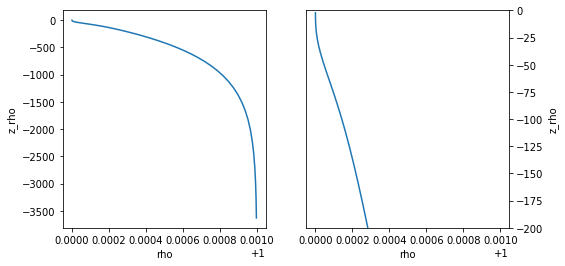

In [23]:
delta_rho = 1e-3
H_tcline = 0.15
H_mld=50/H

ds = xr.Dataset(coords={'z_rho': z})

# rho normalized by rho0
ds['rho'] = (1 
             + delta_rho*(1-np.exp(ds.z_rho/H/H_tcline) )
               * np.tanh(ds.z_rho/H/H_mld)**2
            )

fig, ax = plt.subplots(1,2, figsize=(8,4))
ds.rho.plot(ax=ax[0], y='z_rho')
ds.rho.plot(ax=ax[1], y='z_rho', ylim=(-200,0))
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()

---

### play with 2D FFT

In [24]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

In [25]:
Nx = 256
Ny = Nx*3

kx, ky = (np.fft.fftfreq(n) for n in [Nx, Ny])
kx2 = kx[:,None]+0*ky[None,:]
ky2 = 0*kx[:,None]+ky[None,:]
kk = np.sqrt(kx2**2+ky2**2)

kF = 1/20
dkF = kF/2

psi = (np.exp(-(kk-kF)**2/dkF**2)).astype(np.complex)
psi = psi/np.sqrt(np.sum(abs(psi[:])**2))*Nx*Ny # normalize
#rand = np.random.randn(Ny, Ny)
rand = np.random.uniform(low=-1., high=1., size=(Ny, Ny))
r = np.random.randn(Nx, Ny).astype(np.complex) \
        + 1j*np.random.randn(Nx, Ny).astype(np.complex)
print(np.std(r[:]))
# note r does not respect hermitian symmetry
psi *= r

1.4146550703742269


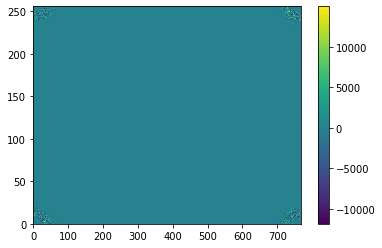

In [26]:
plt.pcolor(np.real(psi))
plt.colorbar()

In [27]:
ipsi = np.fft.ifft2(psi)
ipsi

array([[-0.21136686+0.08416668j, -0.59675435-0.05380903j,
        -0.91705339-0.19558537j, ...,  1.0430303 +0.46253233j,
         0.64143957+0.34863363j,  0.21218048+0.21957837j],
       [-0.05299797+0.04607576j, -0.44803636-0.13889566j,
        -0.7806167 -0.3204052j , ...,  1.22271972+0.59471575j,
         0.81502066+0.42105249j,  0.37861376+0.23454255j],
       [ 0.05819127-0.02254515j, -0.33663804-0.2389584j ,
        -0.67415183-0.44350382j, ...,  1.31629603+0.66433127j,
         0.9162446 +0.43850094j,  0.48595599+0.20540655j],
       ...,
       [-0.75020692+0.0863326j , -1.00447922+0.15161718j,
        -1.20939708+0.20435465j, ...,  0.06293873-0.1170631j ,
        -0.19110753-0.04945302j, -0.47026911+0.01791859j],
       [-0.5926391 +0.0962413j , -0.90898215+0.08758522j,
        -1.16615561+0.06677908j, ...,  0.43635162+0.08542556j,
         0.10950444+0.09645395j, -0.24314951+0.09880079j],
       [-0.40076779+0.09809333j, -0.76093431+0.02012516j,
        -1.05684436-0.06701434

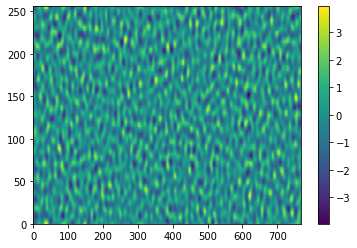

In [28]:
plt.pcolor(np.real(ipsi))
plt.colorbar()

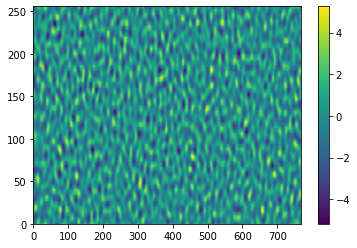

In [29]:
ipsi = np.fft.irfftn(psi[:,:int(Ny/2)+1])
plt.pcolor(ipsi)
plt.colorbar()

In [30]:
np.std(ipsi[:])

1.3759943317818355

---
### Horizontal/Vertical advection (default)
- cppdefs.h

    UV_HADV_UP3
    UV_VADV_SPLINE
    TS_HADV_UP3
    TS_VADV_AKIMA

### Lateral mixing:

- cppdefs.h

    UV_VIS4
    TS_DIF4

- coefficients à 0 dans croco.in

    lateral_visc:   VISC2,    VISC4    [m^2/sec for all]
                    0.0       0.0e+8

    tracer_diff4: TNU4(1:NT)
                  0.0e+8     0.0e+8
              
### Vertical mixing

- cppdefs.h

    !                   Vertical mixing
    # define LMD_MIXING
    # ifdef  LMD_MIXING
    #  undef  ANA_VMIX
    #  define ANA_SRFLUX
    #  define LMD_SKPP
    #  define LMD_BKPP
    #  define LMD_RIMIX
    #  define LMD_CONVEC
    #  undef  LMD_KPP /* this flag seems deprecated !? */
    # endif